# Importing what we need

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import integrate

# Inspecting & cleaning file #1

In [2]:
file = 'LSH-4430 wrong.csv'

df = pd.read_csv(file, 
                 parse_dates=["time"],
                 dayfirst=True,
                 sep=",",          # csv separator
                 decimal=",",      # decimal points
                 quotechar='"',    # handle JMPs quotes in csv files exported from JMP
                 engine="python")  # use python engine to handle quoting

df['time'] = pd.to_datetime(df['time'])
df = df.sort_values("time") # although the raw data is time sorted, we add this one more time just to be safe

df.describe()

,time,FI4700_FlowMeter.Value
count,58862,23057.000000
mean,2025-10-03 13:13:10.195677952,195.863774
min,2025-10-03 05:02:39,0.000000
25%,2025-10-03 09:07:54.249999872,0.162127
50%,2025-10-03 13:13:10.500000,1.783398
75%,2025-10-03 17:18:25.750000128,3.404669
max,2025-10-03 21:23:41,3231.518000
std,NaN,707.355921


In [3]:
df.dtypes

time                      datetime64[ns]
FI4700_FlowMeter.Value           float64
dtype: object

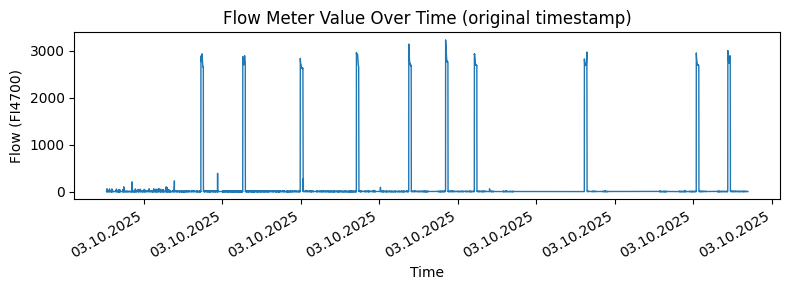

In [4]:
df = df.copy()

df["time"] = pd.to_datetime(df["time"], errors="coerce") # turns bad timestamps into NaT (not a time)
df["FI4700_FlowMeter.Value"] = pd.to_numeric(df["FI4700_FlowMeter.Value"], errors="coerce") # turns non-numeric into NaN (not a number)
                                                                                            # NaN is the default marker for missing numerical data in pandas
# Boolean mask: True if value exists, False if missing
# used to filter rows where flowmeter values are missing
mask = df["FI4700_FlowMeter.Value"].notna()

fig, ax = plt.subplots(figsize=(8, 3))
# df.loc[mask, ...] drops all rows where y is NaN. 
# with the missing points gone, remaining points are now consecutive & therefore connected with straight lines in the plot
ax.plot(df.loc[mask, "time"], df.loc[mask, "FI4700_FlowMeter.Value"], linewidth=1)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m.%Y")) #European date
fig.autofmt_xdate()  # rotate labels

ax.set_title("Flow Meter Value Over Time (original timestamp)")
ax.set_xlabel("Time")
ax.set_ylabel("Flow (FI4700)")
plt.tight_layout()
plt.show()

In [5]:
# add column for seconds passed, i.e., counting up from zero
df['seconds_passed'] = df['time'].diff().dt.total_seconds().fillna(0).cumsum()
df['minutes_passed'] = df['seconds_passed'] / 60
df.head(6)

,time,FI4700_FlowMeter.Value,seconds_passed,minutes_passed
0,2025-10-03 05:02:39,3.404669,0.0,0.000000
1,2025-10-03 05:02:40,NaN,1.0,0.016667
2,2025-10-03 05:02:41,0.162127,2.0,0.033333
3,2025-10-03 05:02:42,NaN,3.0,0.050000
4,2025-10-03 05:02:43,NaN,4.0,0.066667
5,2025-10-03 05:02:44,1.783398,5.0,0.083333


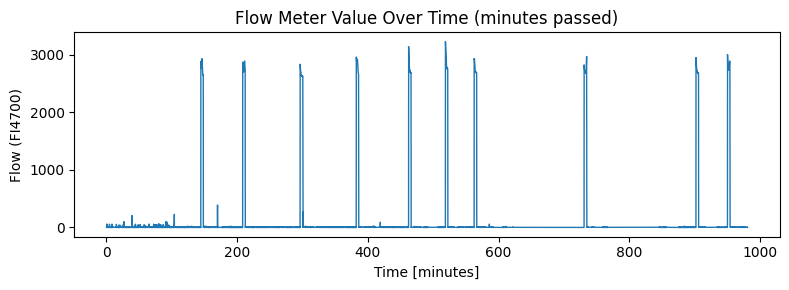

In [6]:
plt.figure(figsize=(8,3))
# df.loc[mask, ...] drops all rows where y is NaN. 
# with the missing points gone, remaining points are now consecutive & therefore connected with straight lines in the plot
plt.plot(df.loc[mask, "minutes_passed"], df.loc[mask, "FI4700_FlowMeter.Value"], linewidth=1)
plt.title("Flow Meter Value Over Time (minutes passed)")
plt.xlabel("Time [minutes]")
plt.ylabel("Flow (FI4700)")
plt.tight_layout()
plt.show()

In [7]:
df.describe()

,time,FI4700_FlowMeter.Value,seconds_passed,minutes_passed
count,58862,23057.000000,58862.000000,58862.000000
mean,2025-10-03 13:13:10.195677952,195.863774,29431.195678,490.519928
min,2025-10-03 05:02:39,0.000000,0.000000,0.000000
25%,2025-10-03 09:07:54.249999872,0.162127,14715.250000,245.254167
50%,2025-10-03 13:13:10.500000,1.783398,29431.500000,490.525000
75%,2025-10-03 17:18:25.750000128,3.404669,44146.750000,735.779167
max,2025-10-03 21:23:41,3231.518000,58862.000000,981.033333
std,NaN,707.355921,16992.506808,283.208447


In [8]:
df.dtypes

time                      datetime64[ns]
FI4700_FlowMeter.Value           float64
seconds_passed                   float64
minutes_passed                   float64
dtype: object

## Conclusion
This looks good, so we're going to inspect file #2 now

<hr>

# Inspecting & cleaning file #2

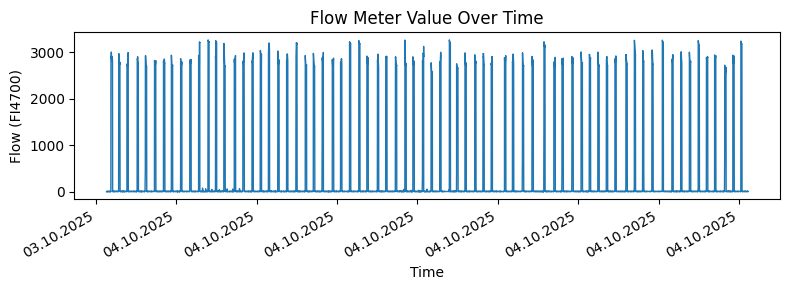

In [9]:
file = 'LSH-4430 right.csv'

df2 = pd.read_csv(file, 
                 parse_dates=["time"],
                 dayfirst=True,
                 sep=",",          # standard CSV separator
                 decimal=",",      # tells pandas that ',' means decimal
                 quotechar='"',    # handle JMP's quotes
                 engine="python")   # python engine handles odd quoting better

df2['time'] = pd.to_datetime(df2['time'])
df2 = df2.sort_values("time")

df2 = df2.copy()

df2["time"] = pd.to_datetime(df2["time"], errors="coerce")
df2["FI4700_FlowMeter.Value"] = pd.to_numeric(df2["FI4700_FlowMeter.Value"], errors="coerce")

mask = df2["FI4700_FlowMeter.Value"].notna()

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(df2.loc[mask, "time"], df2.loc[mask, "FI4700_FlowMeter.Value"], linewidth=1)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%d.%m.%Y")) #European date
fig.autofmt_xdate()  # rotate labels

ax.set_title("Flow Meter Value Over Time")
ax.set_xlabel("Time")
ax.set_ylabel("Flow (FI4700)")
plt.tight_layout()
plt.show()

In [10]:
# add column for seconds passed, i.e., counting up from zero
df2['seconds_passed'] = df2['time'].diff().dt.total_seconds().fillna(0).cumsum()
df2['minutes_passed'] = df2['seconds_passed'] / 60
df2.head()

,time,FI4700_FlowMeter.Value,seconds_passed,minutes_passed
0,2025-10-03 21:23:41,NaN,0.0,0.000000
1,2025-10-03 21:23:42,NaN,1.0,0.016667
2,2025-10-03 21:23:43,NaN,2.0,0.033333
3,2025-10-03 21:23:44,NaN,3.0,0.050000
4,2025-10-03 21:23:45,NaN,4.0,0.066667


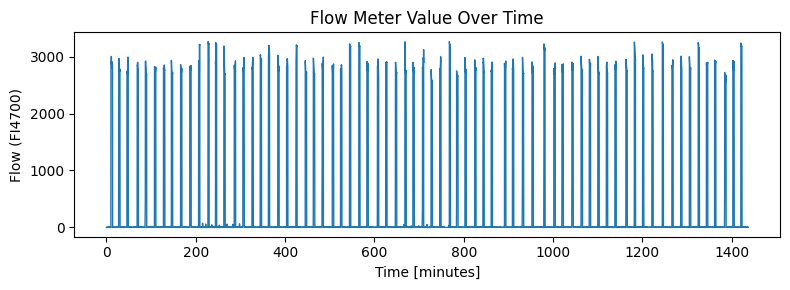

In [11]:
plt.figure(figsize=(8,3))
# df.loc[mask, ...] drops all rows where y is NaN. not used for time, because there are no missing values for time colum
# with the missing points gone, remaining points are now consecutive & therefore connected with straight lines in the plot
plt.plot(df2.loc[mask, "minutes_passed"], df2.loc[mask, "FI4700_FlowMeter.Value"], linewidth=1)
plt.title("Flow Meter Value Over Time")
plt.xlabel("Time [minutes]")
plt.ylabel("Flow (FI4700)")
plt.tight_layout()
plt.show()

In [12]:
df2.describe()

,time,FI4700_FlowMeter.Value,seconds_passed,minutes_passed
count,86174,26870.000000,86174.000000,86174.000000
mean,2025-10-04 09:21:48.526852608,891.120679,43087.526853,718.125448
min,2025-10-03 21:23:41,0.000000,0.000000,0.000000
25%,2025-10-04 03:22:44.249999872,1.783398,21543.250000,359.054167
50%,2025-10-04 09:21:48.500000,3.404669,43087.500000,718.125000
75%,2025-10-04 15:20:52.750000128,2739.624000,64631.750000,1077.195833
max,2025-10-04 21:19:56,3261.835000,86175.000000,1436.250000
std,NaN,1318.013658,24877.295015,414.621584


In [13]:
df2.dtypes

time                      datetime64[ns]
FI4700_FlowMeter.Value           float64
seconds_passed                   float64
minutes_passed                   float64
dtype: object

<hr>

# Integration / getting area under the curve

* Integration is performed using three methods
    * trapez
    * riemann
    * simpson's rule
*  integrations are performed
    * with & without baseline correction
    * with & without resampling & linear interpolation of missing values <br>
      **NB**: resampling in the context of this work is always associated with replacing missing values via linear interpolation.

In [17]:
# ======= CONFIG =======
DATAFRAME_VAR   = "df2"                      # <- change to your dataframe variable name
TIME_COL        = "seconds_passed"          # numeric seconds, increasing
SIGNAL_COL      = "FI4700_FlowMeter.Value"  # only this column is integrated
BASELINE_VALUE  = 1.0                       # constant baseline (kg/h) to subtract in baseline-corrected runs
RESAMPLE_STEP_S = 1.0                       # resampling step in seconds
OUT_FILE        = "integration_summary.csv"
# ======================

# Use np.trapezoid if present (NumPy >= 2.0), else fall back to np.trapz
TRAPZ = getattr(np, "trapezoid", np.trapz)

def resample_uniform_seconds(d, tcol=TIME_COL, ycol=SIGNAL_COL, step=RESAMPLE_STEP_S): # d = original dataframe
    """Uniformly sample (t,y) to a 1-second grid with linear interpolation."""
    sub = d[[tcol, ycol]].dropna().sort_values(tcol)
    t = sub[tcol].to_numpy(dtype=float)
    y = sub[ycol].to_numpy(dtype=float)
    if t.size < 2:
        return sub.copy()
    t_new = np.arange(t[0], t[-1] + 1e-9, step)  # include final point
    y_new = np.interp(t_new, t, y)
    return pd.DataFrame({tcol: t_new, ycol: y_new})

def integrate_all(t, y):
    """Integrate y(t) where y is kg/h and t is seconds. Return kg."""
    t = np.asarray(t, dtype=float)
    y = np.asarray(y, dtype=float)
    m = ~np.isnan(t) & ~np.isnan(y)
    t, y = t[m], y[m]
    if t.size < 2:
        return {"trapz": np.nan, "simpson": np.nan, "riemann_left": np.nan}
    trapz_val = TRAPZ(y, t) / 3600
    try:
        simpson_val = integrate.simpson(y, x=t, even="avg") / 3600
    except TypeError:  # older SciPy
        simpson_val = integrate.simpson(y, x=t) / 3600
    riem_val = np.nansum(y[:-1] * np.diff(t)) / 3600
    return {"trapz": trapz_val, "simpson": simpson_val, "riemann_left": riem_val}

def run_all_integrations(d):
    assert TIME_COL in d.columns and SIGNAL_COL in d.columns, "Time or signal column missing."
    # A) No resampling, no baseline
    rows = []
    rA = integrate_all(d[TIME_COL], d[SIGNAL_COL])                     # rA = result scenario A: no resampling, no baseline correction
    for m, v in rA.items(): rows.append([False, False, m, v])          # m = method name, v = integration result in kg

    # B) Resampling, no baseline
    dr = resample_uniform_seconds(d)                                  # dr = resampled dataframe
    rB = integrate_all(dr[TIME_COL], dr[SIGNAL_COL])                  # rB = scenario B: resampling, no baseline correction
    for m, v in rB.items(): rows.append([True,  False, m, v])

    # C) No resampling, baseline
    db = d.copy()                                                     # db = baseline corrected dataframe
    db[SIGNAL_COL] = db[SIGNAL_COL] - BASELINE_VALUE 
    rC = integrate_all(db[TIME_COL], db[SIGNAL_COL])                  # rC = scenario C: no resampling, with baseline correction
    for m, v in rC.items(): rows.append([False, True,  m, v])

    # D) Resampling + baseline
    drb = resample_uniform_seconds(d)
    drb[SIGNAL_COL] = drb[SIGNAL_COL] - BASELINE_VALUE
    rD = integrate_all(drb[TIME_COL], drb[SIGNAL_COL])                # rD = scenario D: resampling + baseline correction
    for m, v in rD.items(): rows.append([True,  True,  m, v])

    out = pd.DataFrame(rows, columns=["resampled_1s","baseline_corrected","method","integral_kg"])
    out.insert(0, "signal", SIGNAL_COL)
    out.to_csv(OUT_FILE, index=False)
    return out

# ---- Run on the dataframe named in CONFIG ----
df_obj = globals().get(DATAFRAME_VAR)
if df_obj is None:
    raise NameError(f"'{DATAFRAME_VAR}' not found. Set DATAFRAME_VAR to your dataframe variable name.")
results = run_all_integrations(df_obj)
print(f"Saved: {OUT_FILE}")
results.head()


Saved: integration_summary.csv


,signal,resampled_1s,baseline_corrected,method,integral_kg
0,FI4700_FlowMeter.Value,False,False,trapz,9544.926935
1,FI4700_FlowMeter.Value,False,False,simpson,8968.599996
2,FI4700_FlowMeter.Value,False,False,riemann_left,9487.156450
3,FI4700_FlowMeter.Value,True,False,trapz,9544.926935
4,FI4700_FlowMeter.Value,True,False,simpson,9544.972665


<hr>

# Appendix - A
Minimum code for integration of a given dataframe for sanity checking

In [6]:
import numpy as np
import pandas as pd

file = 'LSH-4430 right.csv'

df = pd.read_csv(
    file,
    parse_dates=["time"],
    dayfirst=True,
    sep=",",            # csv separator
    decimal=",",        # decimal separator
    quotechar='"',      # jmp quote character
    engine="python"
)

# Clean columns
df["time"] = pd.to_datetime(df["time"], errors="coerce")
df["FI4700_FlowMeter.Value"] = pd.to_numeric(df["FI4700_FlowMeter.Value"], errors="coerce")

# Keep only good rows and sort
d = (df[["time", "FI4700_FlowMeter.Value"]]
     .dropna(subset=["time", "FI4700_FlowMeter.Value"])
     .sort_values("time")
     .drop_duplicates(subset="time", keep="last"))

# Convert time to numeric seconds (start at 0)
t0 = d["time"].iloc[0]
t_sec = (d["time"] - t0).dt.total_seconds().to_numpy(dtype=float)

# y as float, ensure finite
y = d["FI4700_FlowMeter.Value"].to_numpy(dtype=float)
m = np.isfinite(t_sec) & np.isfinite(y)
t_sec, y = t_sec[m], y[m]

# Choose trapezoid implementation
TRAPZ = getattr(np, "trapezoid", np.trapz)

if t_sec.size < 2:
    area_kg = np.nan
else:
    # y is kg/h, t is seconds → divide by 3600 to get kg
    area_kg = TRAPZ(y, t_sec) / 3600.0

print(f"Area using trapezoidal rule (kg): {area_kg}")


Area using trapezoidal rule (kg): 9544.926934666124


<hr>

# Appendix - B
Creating a new csv file from the existing, original csv file as exported from JMP. The new csv file contains:
* A column for seconds passed since start
* Data is resampled to 1''
* Missing data filled by linear interpolation

In [8]:
import numpy as np
import pandas as pd

# ==== CONFIG ====
IN_FILE  = "LSH-4430 right.csv"
OUT_FILE = "LSH-4430_right_resampled.csv"
TIME_COL = "time"
SIGNAL_COL = "FI4700_FlowMeter.Value"
STEP_S = 1.0
# ===============

# 1) Read + clean
df = pd.read_csv(
    IN_FILE,
    parse_dates=[TIME_COL],
    dayfirst=True,
    sep=",",         # change to ";" if your file is semicolon-separated
    decimal=",",     # treat comma as decimal separator (JMP-style)
    quotechar='"',
    engine="python"
)

df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce")
df[SIGNAL_COL] = pd.to_numeric(df[SIGNAL_COL], errors="coerce")

# Keep only valid rows, sort, and deduplicate by time (keep latest)
d = (df[[TIME_COL, SIGNAL_COL]]
     .dropna(subset=[TIME_COL])
     .sort_values(TIME_COL)
     .drop_duplicates(subset=TIME_COL, keep="last"))

# 2) Build seconds_passed (float seconds from first sample)
if d.empty:
    raise ValueError("No valid timestamps after cleaning the CSV.")

t0 = d[TIME_COL].iloc[0]
d["seconds_passed"] = (d[TIME_COL] - t0).dt.total_seconds()

# 3) Make a strict 1-second grid from 0 to last whole second
t_last = d["seconds_passed"].max()
grid = np.arange(0.0, np.floor(t_last) + STEP_S, STEP_S)

grid_df = pd.DataFrame({"seconds_passed": grid})

# 4) Map original values onto the 1s grid (will be NaN unless a timestamp landed exactly on a whole second)
#    We align by rounding seconds_passed to nearest integer second for display/possible matches
d["_sec_rounded"] = d["seconds_passed"].round().astype(np.int64)
grid_df["_sec_int"] = grid_df["seconds_passed"].astype(np.int64)
orig_on_grid = (d[["_sec_rounded", SIGNAL_COL]]
                .drop_duplicates("_sec_rounded", keep="last")
                .rename(columns={"_sec_rounded": "_sec_int",
                                 SIGNAL_COL: f"{SIGNAL_COL}_orig"}))
grid_df = grid_df.merge(orig_on_grid, on="_sec_int", how="left")

# 5) Interpolate to fill missing values on the 1s grid
#    Use only *real* samples (drop NaN y's), then linear interpolate on the grid
valid = d[[ "seconds_passed", SIGNAL_COL ]].dropna()
if len(valid) >= 2:
    y_interp = np.interp(grid_df["seconds_passed"].to_numpy(),
                         valid["seconds_passed"].to_numpy(),
                         valid[SIGNAL_COL].to_numpy())
else:
    # Not enough data to interpolate
    y_interp = np.full_like(grid_df["seconds_passed"].to_numpy(), np.nan, dtype=float)

grid_df[f"{SIGNAL_COL}_interp"] = y_interp

# 6) Flag which grid points were filled by interpolation (i.e., no original sample matched that second)
grid_df["was_interpolated"] = grid_df[f"{SIGNAL_COL}_orig"].isna() & grid_df[f"{SIGNAL_COL}_interp"].notna()

# 7) (Optional) Keep also the absolute datetime for convenience
grid_df[TIME_COL] = pd.to_datetime(t0) + pd.to_timedelta(grid_df["seconds_passed"], unit="s")

# 8) Order columns and write out
cols = [TIME_COL, "seconds_passed", f"{SIGNAL_COL}_orig", f"{SIGNAL_COL}_interp", "was_interpolated"]
grid_df = grid_df[cols]

# Write CSV (standard '.' decimal). If you want comma-decimal again, add decimal="," to to_csv.
grid_df.to_csv(OUT_FILE, index=False)
print(f"Saved: {OUT_FILE}")


Saved: LSH-4430_right_resampled.csv
